## New Research Qs
1. Is there an significant difference between mortality rates in African vs. non-African countries? [Logistic Regression or Naive Bayes]
2. Is there a significant difference between the explanatory variables (features) we consider in African vs. non-African countries? [Quadratic Discriminant Analysis]
3. (Assuming there is a difference from (1) and (2)) Can we create a predictive model to predict adult mortality, given a set of explanatory data for an African country? [try Linear Regression (w Regularization) AND KMeans]

In [165]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [166]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [167]:
! pip install xgboost

## Import the Data

In [168]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("kumarajarshi/life-expectancy-who")

print("Path to dataset files:", path)

WHO = pd.read_csv('/root/.cache/kagglehub/datasets/kumarajarshi/life-expectancy-who/versions/1/Life Expectancy Data.csv')

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

world = gpd.read_file('/content/drive/MyDrive/worldmap.gpkg')
world.rename(columns={"SOVEREIGNT": "Country"}, inplace=True)

Path to dataset files: /root/.cache/kagglehub/datasets/kumarajarshi/life-expectancy-who/versions/1


## Initial Data Analysis

<Axes: >

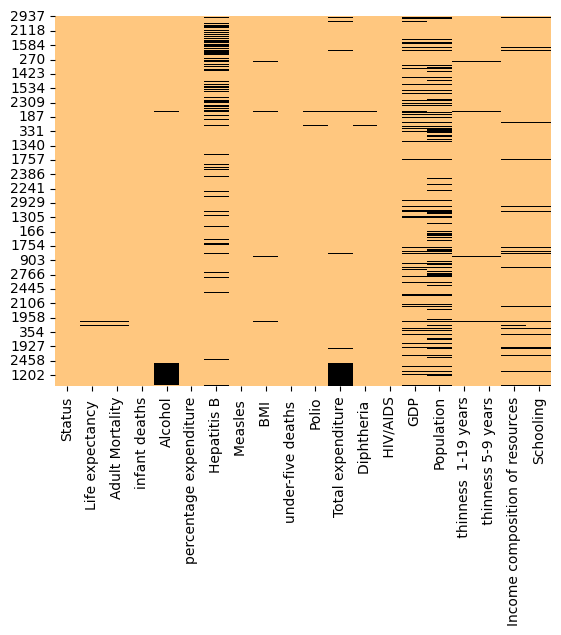

In [169]:
import matplotlib

# Visualize missing data
df1 = WHO.drop('Country', axis=1)

df1[list(set(df1.columns) - {'Year'})] = df1[list(set(df1.columns) - {'Year'})].isnull()
sns.heatmap(df1.sort_values('Year').drop('Year', axis=1, inplace=False), cmap="copper_r", cbar=False)

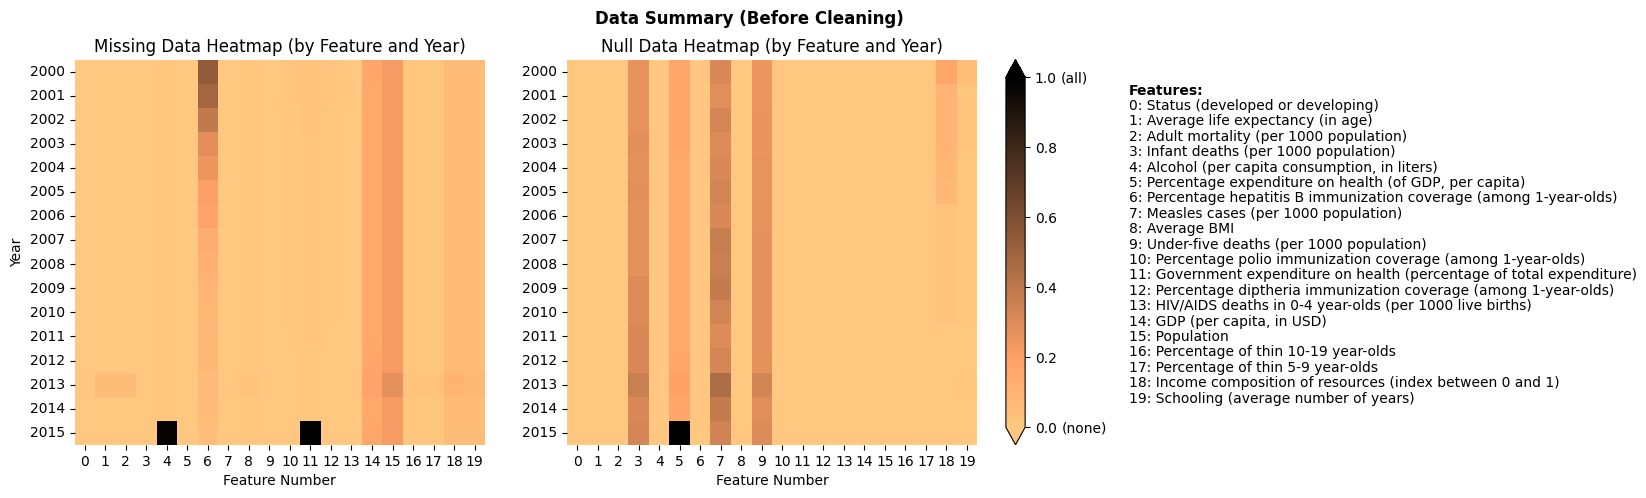

In [170]:
plt.figure(figsize=(18,5))

df1 = df1.groupby('Year').sum()

plt.subplot(1,3,1)
sns.heatmap(df1 / 183, cmap="copper_r", cbar=False)
plt.title("Missing Data Heatmap (by Feature and Year)")
plt.xticks(plt.gca().get_xticks(), np.arange(len(df1.columns)), rotation=0)
plt.xlabel("Feature Number")

# Visualize null data
df2 = WHO.drop('Country', axis=1)

df2[list(set(df2.columns) - {'Year'})] = df2[list(set(df2.columns) - {'Year'})] == 0
df2 = df2.groupby('Year').sum()

plt.subplot(1,3,2)
sns.heatmap(df2 / 183, cmap="copper_r", cbar=False)
plt.title("Null Data Heatmap (by Feature and Year)")
plt.xticks(plt.gca().get_xticks(), np.arange(len(df2.columns)), rotation=0)
plt.xlabel("Feature Number")
plt.ylabel("")

ax = plt.subplot(1,3,3)
fraction = 1.13  # .05

norm = matplotlib.colors.Normalize(vmin=0, vmax=1)
cbar = ax.figure.colorbar(
            matplotlib.cm.ScalarMappable(norm=norm, cmap='copper_r'),
            ax=ax, pad=-0.3, extend='both', fraction=fraction)

ax.axis('off')

plt.text(1, 0.91, "Features:", weight='bold')
cols = WHO.columns[list(range(2,22))]

cols = ['Status (developed or developing)', 'Average life expectancy (in age)', 'Adult mortality (per 1000 population)', 'Infant deaths (per 1000 population)', 'Alcohol (per capita consumption, in liters)',
        'Percentage expenditure on health (of GDP, per capita)', 'Percentage hepatitis B immunization coverage (among 1-year-olds)', 'Measles cases (per 1000 population)', 'Average BMI',
        'Under-five deaths (per 1000 population)', 'Percentage polio immunization coverage (among 1-year-olds)', 'Government expenditure on health (percentage of total expenditure)',
        'Percentage diptheria immunization coverage (among 1-year-olds)', 'HIV/AIDS deaths in 0-4 year-olds (per 1000 live births)', 'GDP (per capita, in USD)', 'Population',
        'Percentage of thin 10-19 year-olds', 'Percentage of thin 5-9 year-olds', 'Income composition of resources (index between 0 and 1)', 'Schooling (average number of years)']

for i in range(len(cols)):
    plt.text(1, 0.91-0.04*(i+1), f"{i}: {cols[i]}")

plt.text(0.03, 0.033, "(none)")
plt.text(0.02, 0.942, "(all)")

plt.suptitle("Data Summary (Before Cleaning)", weight="bold")
plt.show()

**Null data**:
1. Some countries have 0 infant deaths (per 1000 population) which is sus; maybe the data wasn't gathered.
2. Some countries have 0% percentage expenditure of GDP per capita; maybe the data wasn't available yet for 2015.
3. Some countries have 0 measles cases (per 1000 population); this is reasonable for developed countries.
4. Some countries have 0 under-five deaths (per 1000 population); maybe the data wasn't gathered.

**Missing data**:
1. Mortality rates in 2012. These rows should be dropped.
2. Alcohol consumption in 2015.
3. Govt expenditure in 2015.
4. Percentage hep B immunizations
5. GDP per capita
6. Population
7. In some countries, income composition of resources
8. In some countries, schooling data.


### Data Cleaning Steps
1. Determine features that are missing or contain bad data.
2. Determine features that are colinear using the correlation matrix.
3. Eliminate colinear features, carefully choosing/justifying which one we remove.
4. Create one or two new features (feature engineering)

The top ten most correlated feature pairs are the following:
1. Thinness 5-9 years and thinness 1-19 years
2. GDP and percentage expenditure
3. Income composition of resources and schooling
4. Polio and diptheria
5. Hepatitis B and diptheria
6. Alcohol and Status
7. Population and infant deaths
8. Population and under-five deaths
9. Alcohol and schooling
10. Thinness 5-9 years and BMI

Consider doing the following:
0. Remove Life expectancy (obvious)
1. Remove thinness 5-9 years (correlated with two others)
2. Remove percentage expenditure (correlated with GDP)
3. Remove GDP (because we care more about health expenditure as a % of GDP)
4. Remove income composition of resources (correlated with schooling, and we already have economic data from GDP)
5. Remove status (this is sort of an engineered feature in its own right, rather than a fundamental description of the data)
6. Copy alcohol data from 2014 into 2015. And copy government expenditure on health from 2014 to 2015.
7. For the three immunization features (diptheria, hep B, polio), average the ones we have into a new immunizations feature.
8. Delete the infant mortality and under-5 deaths columns (lots of suspicious 0s)

In [171]:
# Get the columns of the WHO dataset
print(WHO.columns)

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling'],
      dtype='object')


In [172]:
df = WHO.copy()

df.drop(['infant deaths', 'under-five deaths '], axis=1, inplace=True)
df.drop(df.index[df['Adult Mortality'].isna()], inplace=True)

expenditure_2014 = df.loc[df.index[df['Year'] == 2014], 'Total expenditure']
expenditure_2014.index = expenditure_2014.index - 1
df.loc[df.index[df['Year'] == 2015], 'Total expenditure'] = expenditure_2014

# Drop BMI and replace with our engineered features
df.drop(" BMI ",axis=1,inplace=True)
obese = pd.read_csv('/content/drive/MyDrive/OBESITY - data-2.csv')
underweight = pd.read_csv('/content/drive/MyDrive/Underweight - data-2-2.csv')

obese.rename(columns={"Location": "Country","Period":"Year","Value":"Obesity"}, inplace=True)
obese.drop("Period type",axis=1,inplace=True)
underweight.drop("Period type",axis=1,inplace=True)
underweight.rename(columns={"Location": "Country","Period":"Year","Value":"Underweight"}, inplace=True)

# Quick analysis of which countries get dropped
df = df.merge(underweight,on=["Country","Year"])
df = df.merge(obese,on=["Country","Year"])

from tabulate import tabulate

threshold = 0.9
print(f"Nominal explanatory variables with absolute value of correlation > {threshold}:")

corr_df = df[list(set(df.columns) - {'Country','Year','Adult Mortality','Status','Life expectancy '})].corr()
corr_df = corr_df.corr()

corr_df = corr_df[corr_df.abs() > threshold]
corr_df[corr_df.isna()] = np.inf

cats = corr_df.columns

tuples = set()
table_rows = list()

for index, row in corr_df.iterrows():
    for column, value in row.items():
        if value not in {1,np.inf}:
            feat1 = index
            feat2 = column
            if (feat2, feat1) in tuples:
                continue

            table_rows.append([feat1, feat2, corr_df.loc[feat1].loc[feat2]])
            tuples.add((feat1, feat2))

print(tabulate(table_rows, headers=["Feature 1", "Feature 2", "Values"], tablefmt="fancy_grid"))

Nominal explanatory variables with absolute value of correlation > 0.9:
╒═════════════════════════════════╤══════════════════════╤═══════════╕
│ Feature 1                       │ Feature 2            │    Values │
╞═════════════════════════════════╪══════════════════════╪═══════════╡
│ Income composition of resources │ Underweight          │ -0.927858 │
├─────────────────────────────────┼──────────────────────┼───────────┤
│ Income composition of resources │ thinness  1-19 years │ -0.901639 │
├─────────────────────────────────┼──────────────────────┼───────────┤
│ Income composition of resources │ Schooling            │  0.982909 │
├─────────────────────────────────┼──────────────────────┼───────────┤
│ Underweight                     │ thinness  1-19 years │  0.961684 │
├─────────────────────────────────┼──────────────────────┼───────────┤
│ Underweight                     │ thinness 5-9 years   │  0.96196  │
├─────────────────────────────────┼──────────────────────┼───────────┤
│ Und

In [173]:
# Engineer the column for immunizations, using the mean of the columns (of the three) that we have
# Drop any rows for which we have no immunizations data
df['Immunizations'] = df[['Hepatitis B', 'Polio', 'Diphtheria ']].mean(skipna=True, axis=1)
df.drop(df.index[df['Immunizations'].isna()], inplace=True)
df.drop(['Hepatitis B', 'Polio', 'Diphtheria '], axis=1, inplace=True)

# Copy alcohol and health expenditure data from 2014 into 2015
alcohol_2014 = df.loc[df.index[df['Year'] == 2014], 'Alcohol']
alcohol_2014.index = alcohol_2014.index - 1
df.loc[df.index[df['Year'] == 2015], 'Alcohol'] = alcohol_2014

# Drop the features we decided to drop; also drop the rows with NA values
df.drop([' thinness 5-9 years', 'percentage expenditure', 'GDP', 'Income composition of resources', 'Status',
         'Population', 'Life expectancy ', ' thinness  1-19 years', ' thinness 5-9 years', 'Underweight'], axis=1., inplace=True)

#Add whether a country is in africa
african_countries = [
    'Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cameroon',
    'Cape Verde', 'Cabo Verde', 'Central African Republic', 'Chad', 'Comoros', 'Congo',
    "Cote d'Ivoire", 'Democratic Republic of Congo', 'Djibouti', 'Egypt',
    'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia',
    'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya',
    'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco',
    'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe',
    'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan',
    'Sudan', 'Swaziland', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'
]

not_african_countries = WHO.Country.unique()
not_african_countries = [country for country in not_african_countries if country not in african_countries]

#One hot encode whether a country is in africa or not for logistic regression
df["Response"] = df.Country.isin(african_countries).astype(float)

# Drop remaining rows in the dataset which have NA values and add a constant column
df.insert(0, 'Const', 1)
df.dropna(inplace=True)

display(df)

,Const,Country,Year,Adult Mortality,Alcohol,Measles,Total expenditure,HIV/AIDS,Schooling,Obesity,Immunizations,Response
0,1,Afghanistan,2015,263.0,0.01,1154,8.18,0.1,10.1,12.6,45.333333,0.0
1,1,Afghanistan,2014,271.0,0.01,492,8.18,0.1,10.0,11.7,60.666667,0.0
2,1,Afghanistan,2013,268.0,0.01,430,8.13,0.1,9.9,11.0,63.333333,0.0
3,1,Afghanistan,2012,272.0,0.01,2787,8.52,0.1,9.8,10.3,67.000000,0.0
4,1,Afghanistan,2011,275.0,0.01,3013,7.87,0.1,9.5,9.6,68.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2923,1,Zimbabwe,2004,723.0,4.36,31,7.13,33.6,9.2,7.7,66.666667,1.0
2924,1,Zimbabwe,2003,715.0,4.06,998,6.52,36.7,9.5,7.5,27.333333,1.0
2925,1,Zimbabwe,2002,73.0,4.43,304,6.53,39.8,10.0,7.3,72.333333,1.0
2926,1,Zimbabwe,2001,686.0,1.72,529,6.16,42.1,9.8,7.1,75.666667,1.0


In [174]:
threshold = 0.7
print(f"Nominal explanatory variables with absolute value of correlation > {threshold}:")

corr_df = df[list(set(df.columns) - {'Country','Year','Adult Mortality','Response'})].corr()
corr_df = corr_df.corr()

corr_df = corr_df[corr_df.abs() > threshold]
corr_df[corr_df.isna()] = np.inf

cats = corr_df.columns

tuples = set()
table_rows = list()

for index, row in corr_df.iterrows():
    for column, value in row.items():
        if value not in {1,np.inf}:
            feat1 = index
            feat2 = column
            if (feat2, feat1) in tuples:
                continue

            table_rows.append([feat1, feat2, corr_df.loc[feat1].loc[feat2]])
            tuples.add((feat1, feat2))

print(tabulate(table_rows, headers=["Feature 1", "Feature 2", "Values"], tablefmt="fancy_grid"))

Nominal explanatory variables with absolute value of correlation > 0.7:
╒═════════════╤═════════════╤═══════════╕
│ Feature 1   │ Feature 2   │    Values │
╞═════════════╪═════════════╪═══════════╡
│ HIV/AIDS    │ Schooling   │ -0.723158 │
╘═════════════╧═════════════╧═══════════╛


###OLS analysis with SM


In [175]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


X = df.drop(["Adult Mortality", "Country","Response"], axis=1)
X_float = X.astype(float)

y = df["Adult Mortality"]
y_float = y.astype(float)

sol = sm.OLS(y_float, X_float).fit()

africa = df.loc[df.Country.isin(african_countries)]
outside = df.loc[df.Country.isin(not_african_countries)]

africa = africa.drop(['Country','Response'], axis=1)
outside = outside.drop(['Country','Response'], axis=1)

X_A = africa.drop(['Adult Mortality'], axis=1)
y_A = africa.loc[:,'Adult Mortality']

print(X_A.columns)

X_A = X_A.astype(float)
y_A = y_A.astype(float)

sol_a = sm.OLS(y_A, X_A).fit()

print("SOL_A SUMMARY")
print(sol_a.summary2())

X_O = outside.drop('Adult Mortality', axis=1).astype(float)
y_O = outside.loc[:,'Adult Mortality'].astype(float)

sol_o = sm.OLS(y_O, X_O).fit()

print("SOL_O SUMMARY")
print(sol_o.summary2())

print(sol.params.astype(float))
print(X.mean(axis=0).astype(float))

Index(['Const', 'Year', 'Alcohol', 'Measles ', 'Total expenditure',
       ' HIV/AIDS', 'Schooling', 'Obesity', 'Immunizations'],
      dtype='object')
SOL_A SUMMARY
                      Results: Ordinary least squares
Model:                  OLS                 Adj. R-squared:        0.266    
Dependent Variable:     Adult Mortality     AIC:                   9935.0975
Date:                   2024-12-13 06:11    BIC:                   9977.0772
No. Observations:       784                 Log-Likelihood:        -4958.5  
Df Model:               8                   F-statistic:           36.51    
Df Residuals:           775                 Prob (F-statistic):    3.08e-49 
R-squared:              0.274               Scale:                 18454.   
----------------------------------------------------------------------------
                    Coef.     Std.Err.    t    P>|t|     [0.025     0.975]  
----------------------------------------------------------------------------
Const     

###Visual of mortality over time for analysis

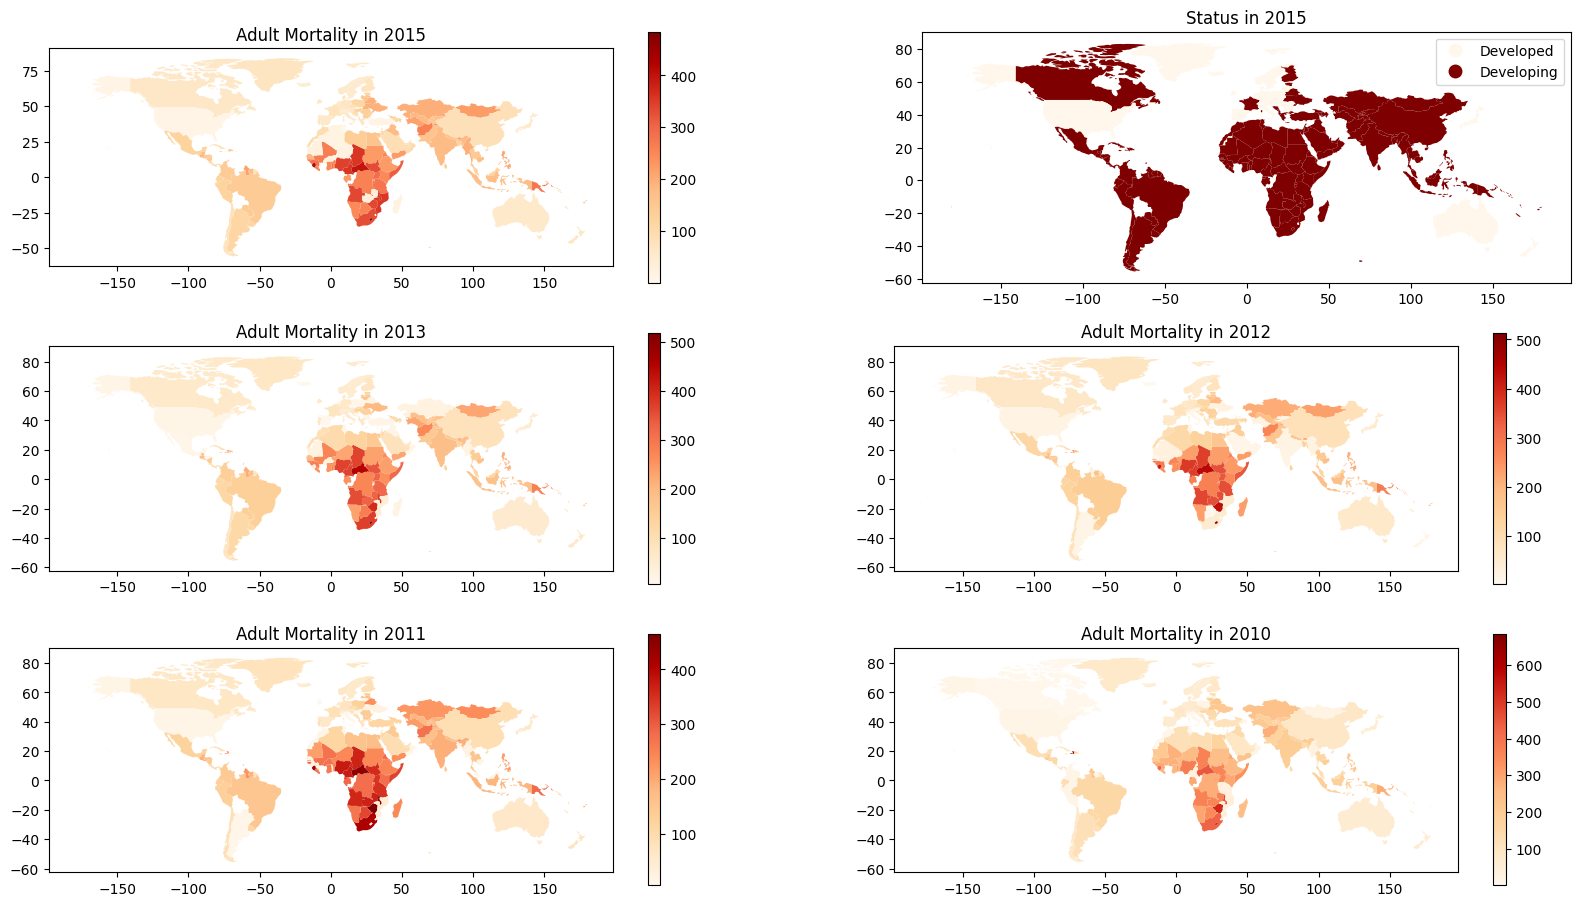

In [176]:
WHO = pd.read_csv('/root/.cache/kagglehub/datasets/kumarajarshi/life-expectancy-who/versions/1/Life Expectancy Data.csv')

world2015 = world.merge(WHO[WHO['Year'] == 2015], on='Country')
world2014 = world.merge(WHO[WHO['Year'] == 2014], on='Country')
world2013 = world.merge(WHO[WHO['Year'] == 2013], on='Country')
world2012 = world.merge(WHO[WHO['Year'] == 2012], on='Country')
world2011 = world.merge(WHO[WHO['Year'] == 2011], on='Country')
world2010 = world.merge(WHO[WHO['Year'] == 2010], on='Country')

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(4, 2, 1)
ax2 = fig.add_subplot(4, 2, 2)
ax3 = fig.add_subplot(4, 2, 3)
ax4 = fig.add_subplot(4, 2, 4)
ax5 = fig.add_subplot(4, 2, 5)
ax6 = fig.add_subplot(4, 2, 6)

world2015.plot(column="Adult Mortality", cmap="OrRd", legend=True,  ax=ax1, aspect=1)
ax1.set_title("Adult Mortality in 2015")
world2015.plot(column="Status", cmap="OrRd", legend=True,  ax=ax2, aspect=1)
ax2.set_title("Status in 2015")
world2013.plot(column="Adult Mortality", cmap="OrRd", legend=True,  ax=ax3)
ax3.set_title("Adult Mortality in 2013")
world2012.plot(column="Adult Mortality", cmap="OrRd", legend=True,  ax=ax4)
ax4.set_title("Adult Mortality in 2012")
world2011.plot(column="Adult Mortality", cmap="OrRd", legend=True,  ax=ax5)
ax5.set_title("Adult Mortality in 2011")
world2010.plot(column="Adult Mortality", cmap="OrRd", legend=True,  ax=ax6)
ax6.set_title("Adult Mortality in 2010")
plt.show()

####Logistic Regression analysis for Africa vs Non-African (Answering question 1)

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = df["Adult Mortality"]
X = X.astype(float).to_numpy()

y = df["Response"]
y = y.astype(float).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

model = LogisticRegression(max_iter=200,fit_intercept=True).fit(X_train.reshape(-1,1),y_train)
LinReg_score = model.score(X_test.reshape(-1,1),y_test)

In [178]:
print(LinReg_score)

0.8475138121546961


###QDA for the features (Answering question 2)

In [179]:
#QDA for the features (Answering question 2)
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


X = df.drop(["Adult Mortality", "Country","Response","Year"], axis=1)
X = X.astype(float).to_numpy()

y = df["Response"]
y = y.astype(float).to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

QDA = QuadraticDiscriminantAnalysis(reg_param=.41,store_covariance=True)
QDA.fit(X_train, y_train)
QDA_score = QDA.score(X_test,y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [180]:
print(QDA_score)

0.8850828729281768


###Part 3, trying to build a predictive model for Adult mortality

In [181]:
#XGB normal regression
import xgboost as xgb
from sklearn.metrics import mean_squared_error as MSE

X = df.drop(["Adult Mortality", "Country","Response"], axis=1)
X_float = X.astype(float)

y = df["Adult Mortality"]
y_float = y.astype(float)

africa = df.loc[df.Country.isin(african_countries)]
outside = df.loc[df.Country.isin(not_african_countries)]

africa = africa.drop(['Country','Response'], axis=1)
outside = outside.drop(['Country','Response'], axis=1)

X_A = africa.drop(['Adult Mortality'], axis=1).astype(float)
y_A = africa.loc[:,'Adult Mortality'].astype(float)

X_O = outside.drop('Adult Mortality', axis=1).astype(float)
y_O = outside.loc[:,'Adult Mortality'].astype(float)


Xa_train, Xa_test, ya_train, ya_test = train_test_split(X_A, y_A, test_size=0.33,random_state=42)
Xo_train, Xo_test, yo_train, yo_test = train_test_split(X_O, y_O, test_size=0.33,random_state=42)

XG = xgb.XGBRegressor()
XG.fit(Xo_train,yo_train)
pred_xg_O = XG.predict(Xo_test)
MSE_score_xgb_O = MSE(yo_test, pred_xg_O)

XG.fit(Xa_train,ya_train)
pred_xg_A = XG.predict(Xa_test)
MSE_score_xgb_A = MSE(ya_test, pred_xg_A)

In [182]:
print("MSE for XGB Africa: ",MSE_score_xgb_A)
print("MSE for XGB Outside Africa: ", MSE_score_xgb_O)

MSE for XGB Africa:  21628.61884886571
MSE for XGB Outside Africa:  3510.0913117000496


In [183]:
#K Nearest Neighbors regression
from sklearn.neighbors import KNeighborsRegressor
KNR = KNeighborsRegressor()
KNR.fit(Xa_train,ya_train)
pred_knr_A = KNR.predict(Xa_test)
MSE_score_knr_A = MSE(ya_test, pred_knr_A)

KNR.fit(Xo_train,yo_train)
pred_knr_O = KNR.predict(Xo_test)
MSE_score_knr_O = MSE(yo_test, pred_knr_O)

In [184]:
print("MSE for KNR Africa: ",MSE_score_knr_A)
print("MSE for KNR Outside Africa: ", MSE_score_knr_O)

MSE for KNR Africa:  22868.740077220078
MSE for KNR Outside Africa:  5033.5357894736835


In [185]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor()

RF.fit(Xa_train,ya_train)
pred_rf_A = RF.predict(Xa_test)
MSE_score_rf_A = MSE(ya_test, pred_rf_A)

RF.fit(Xo_train,yo_train)
pred_rf_O = RF.predict(Xo_test)
MSE_score_rf_O = MSE(yo_test, pred_rf_O)

In [186]:
print("MSE for Random Forest Africa: ",MSE_score_rf_A)
print("MSE for Random Forest Outside Africa: ", MSE_score_rf_O)

MSE for Random Forest Africa:  17350.393130888035
MSE for Random Forest Outside Africa:  3046.6592122291017


In [187]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
XGB = xgb.XGBRegressor()
parameters = {'learning_rate': [0.001, 0.01, .03, 0.05, .07, 0.1, 0.2],
              'max_depth': [3, 5, 6, 7],
              'min_child_weight': [4],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(XGB,
                        parameters,
                        verbose=True)

In [188]:
xgb_grid.fit(Xa_train,ya_train)
pred_xgb_grid_A = xgb_grid.predict(Xa_test)
MSE_score_xgb_grid_A = MSE(ya_test,pred_xgb_grid_A)

xgb_grid.fit(Xo_train,yo_train)
pred_xgb_grid_O = xgb_grid.predict(Xo_test)
MSE_score_xgb_grid_O = MSE(yo_test,pred_xgb_grid_O)


print("MSE for gridsearch XGB Africa: ", MSE_score_xgb_grid_A)
print("MSE for gridsearch XGB Outside Africa: ", MSE_score_xgb_grid_O)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
Fitting 5 folds for each of 28 candidates, totalling 140 fits
MSE for gridsearch XGB Africa:  17308.3228320658
MSE for gridsearch XGB Outside Africa:  3256.0214598604966


In [189]:
OLS_A = sm.OLS(ya_train, Xa_train).fit()
pred_ols_A = OLS_A.predict(Xa_test)
MSE_score_ols_A = MSE(ya_test,pred_ols_A)

OLS_O = sm.OLS(yo_train, Xo_train).fit()
pred_ols_O = OLS_O.predict(Xo_test)
MSE_score_ols_O = MSE(yo_test,pred_ols_O)

print("MSE for OLS Africa: ", MSE_score_ols_A)
print("MSE for OLS Outside Africa: ", MSE_score_ols_O)

MSE for OLS Africa:  17088.488180422137
MSE for OLS Outside Africa:  4045.707886767336


In [190]:
from sklearn.ensemble import VotingRegressor

X = df.drop(["Adult Mortality", "Country","Response","Year"], axis=1)
X = X.astype(float).to_numpy()
y = df["Adult Mortality"]
y = y.astype(float).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

xg = xgb.XGBRegressor()
rf = RandomForestRegressor()
kn = KNeighborsRegressor()


vote = VotingRegressor([('xg', xg), ('rf', rf), ('kn', kn)],weights=[.1,.7,.2])
vote.fit(X_train,y_train)

VotingRegressor(estimators=[('xg',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('rf', RandomForestRegressor()),
                            ('kn', KNeighborsRegressor())],
                weights=[0.1, 0.7, 0.2])

In [191]:
pred_vote = vote.predict(X_test)

In [192]:
vote_MSE = MSE(y_test,pred_vote)
print(vote_MSE)

7874.11294643846


###Printing the top features

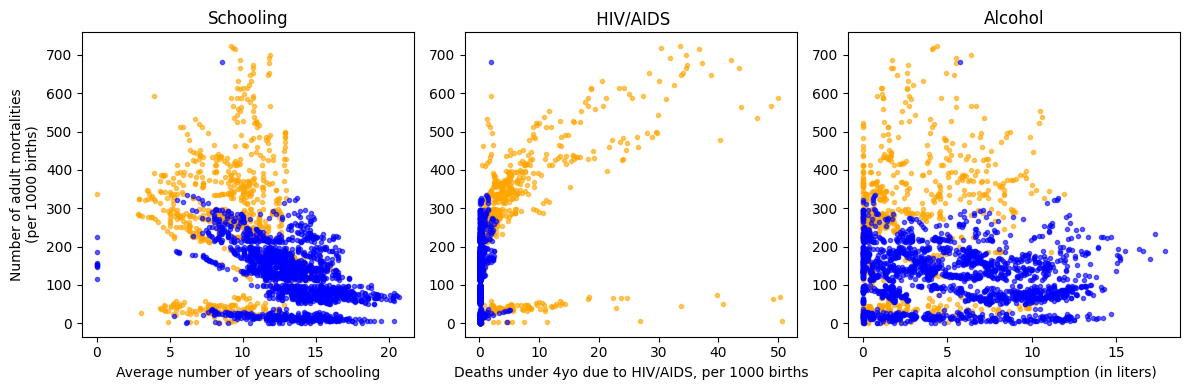

In [194]:
plt.figure(figsize=(12,4))
X = df.drop(["Adult Mortality", "Country","Response"], axis=1)
for i, feature in enumerate(['Schooling', ' HIV/AIDS', 'Alcohol']):
    beta_i_a = sol_a.params[feature]
    beta_i_o = sol_o.params[feature]

    domain = np.linspace(min(X[feature]), max(X[feature]), 100)

    plt.subplot(1, 3, i + 1)
    plt.scatter(X_A[feature].astype(float), y_A, color="orange", alpha=0.6, marker='.', label="Africa")
    plt.scatter(X_O[feature].astype(float), y_O, color="blue", alpha=0.6, marker='.', label="Not Africa")
    if i == 0:
        plt.ylabel("Number of adult mortalities\n(per 1000 births)")
        plt.xlabel("Average number of years of schooling")
    if i == 1:
        plt.xlabel("Deaths under 4yo due to HIV/AIDS, per 1000 births")
    if i == 2:
        plt.xlabel("Per capita alcohol consumption (in liters)")
    plt.title(feature)

    # plt.plot(domain, sol.params.astype(float).dot(X.mean(axis=0).astype(float)) \
    #          + beta_i_a*(domain - X[feature].mean()), label="Average OLS",
    #          color="orange", linestyle="--")

    # plt.subplot(2, 3, 3 + i + 1)
    # plt.title(feature + " (Non-Africa)\n" + rf"$\beta_i={beta_i_o:.3f}$")
    # plt.plot(domain, sol.params.astype(float).dot(X.mean(axis=0).astype(float)) \
    #          + beta_i_o*(domain - X[feature].mean()), label="Average OLS",
    #          color="blue", linestyle="--")

plt.tight_layout()
plt.show()